In [1]:
from util.MicFileTool import MicFile
import util.Simulation as Gsim
import util.RotRep as Rot
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import h5py
from scipy.signal import convolve2d
import os
from scipy.ndimage.measurements import label,find_objects,center_of_mass
from util_mjw.calibration_misc import fetch

In [2]:
from config import Config
Cfg = Config('ConfigFiles/RealG15_mjw.yml')


# Read Grain Map from the LBFS File

In [3]:
a=MicFile("AuxData/Ti7_WithHRM_2ndLoad_z1_.mic.LBFS")

-0.556875 -0.00974279 0 2 7 1 281.746 88.7135 78.1765 0.145161 0.885753 0.14876 0 1 1 1 0 0 0

<class 'str'>
sw is 0.72 

shape of snp is (32855, 19)


88.6761
(400, 350) (400, 350)


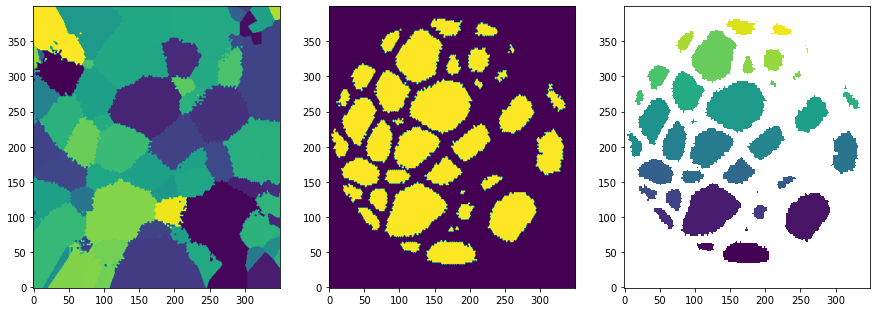

In [84]:
grid_x,grid_y=np.meshgrid(np.arange(-0.5,0.2,0.002),np.arange(-0.4,0.4,0.002))
grid_c = griddata(a.snp[:,0:2],a.snp[:,9],(grid_x,grid_y),method='nearest')
grid_e1 = griddata(a.snp[:,0:2],a.snp[:,6],(grid_x,grid_y),method='nearest')
grid_e2 = griddata(a.snp[:,0:2],a.snp[:,7],(grid_x,grid_y),method='nearest')
grid_e3 = griddata(a.snp[:,0:2],a.snp[:,8],(grid_x,grid_y),method='nearest')
print(grid_e1[10,10])
g = np.where(grid_c>0.8,1,0)

labels,num_features = label(g)

ll = np.float32(labels.copy())
ll[ll==0] = np.nan

print(grid_x.shape,grid_e1.shape)
fig,ax = plt.subplots(ncols=3,figsize=(15,7))
ax[0].imshow(grid_e3,origin='lower')
ax[1].imshow(g,origin='lower')
ax[2].imshow(ll,origin='lower')
plt.show()

In [79]:
GrainDict={}
for l in np.sort(np.unique(labels))[1:]:
    
    com =center_of_mass(g,labels,l)
    com = (int(com[0]),int(com[1]))
    GrainDict[l] = (grid_e1[com],grid_e2[com],grid_e3[com])


In [80]:
GrainIDMap=np.zeros(grid_c.shape,dtype=int)
for grainID in GrainDict:
    
    (e1,e2,e3)=GrainDict[grainID]
    tmp = grid_c > 0.3
    tmp*=np.absolute(grid_e1 - e1)<1
    tmp*=np.absolute(grid_e2 - e2)<1
    tmp*=np.absolute(grid_e3 - e3)<1
    GrainIDMap[tmp]= grainID #* tmp
print(np.unique(GrainIDMap))

[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 28 29 30 31 32 33 34 37 38 39 40]


[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 28 29 30 31 32 33 34 37 38 39 40]


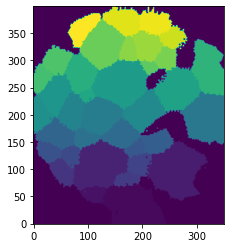

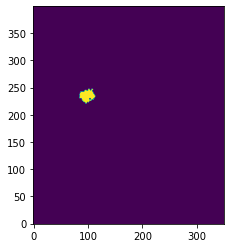

In [81]:
gg = np.where(GrainIDMap==24,1,0)
print(np.unique(GrainIDMap))
plt.imshow(GrainIDMap,origin='lower')
plt.show()
plt.imshow(gg,origin='lower')
plt.show()

In [82]:

with h5py.File(Cfg.micFile,'w') as f:
    ds=f.create_dataset("origin", data = np.array([-0.5,-0.4]))
    ds.attrs[u'units'] = u'mm'
    ds=f.create_dataset("stepSize", data = np.array([0.002,0.002]))
    ds.attrs[u'units'] = u'mm'
    f.create_dataset("Xcoordinate", data = grid_x)
    f.create_dataset("Ycoordinate", data = grid_y)
    f.create_dataset("Confidence", data = grid_c)
    f.create_dataset("Ph1", data = grid_e1)
    f.create_dataset("Psi", data = grid_e2)
    f.create_dataset("Ph2", data = grid_e3)
    f.create_dataset("GrainID", data = GrainIDMap)

# Create HDF5 File for the Bragg Peaks of One Grain

In [9]:
energy = Cfg.energy
etalimit=Cfg.etalimit/180.0*np.pi

########################
# Detector parameters (after my recalibration of 2nd) 
########################

Det=Gsim.Detector(psizeJ=Cfg.pixelSize*1e-3,psizeK=Cfg.pixelSize*1e-3)
Det.Move(Cfg.JCenter,Cfg.KCenter,np.array([Cfg.Ldistance,0,0]),Rot.EulerZXZ2Mat(np.array(Cfg.tilt)/180.0*np.pi))


#########################
# Default Ti7 LP
#########################
Ti7=Gsim.CrystalStr()
Ti7.PrimA = Cfg.lattice[0] * np.array([1, 0, 0])
Ti7.PrimB = Cfg.lattice[1] * np.array([np.cos(np.pi * 2 / 3), np.sin(np.pi * 2 / 3), 0])
Ti7.PrimC = Cfg.lattice[2] * np.array([0, 0, 1])
Atoms = Cfg.atoms
for ii in range(len(Atoms)):
    Ti7.addAtom(list(map(eval, Atoms[ii][0:3])), Atoms[ii][3])

Ti7.getRecipVec()
Ti7.getGs(Cfg.maxQ)

In [16]:
import yaml

grain_Ids = np.unique(GrainIDMap)[1:]
with open('ConfigFiles/RealG_15.yml') as f:
    data = yaml.safe_load(f)
grain_posi = []

for i in grain_Ids:
    i = int(i)
    locations = np.where(GrainIDMap==i,1,0)
    
    com_ind = np.int32(np.round(center_of_mass(locations)))
    
    grain_pos = np.round(np.array([ grid_x[com_ind[0],com_ind[1]],grid_y[com_ind[0],com_ind[1]],0]),4)
    grain_posi.append(grain_pos)
    euler = np.array([grid_e1[locations==1].mean(),grid_e2[locations==1].mean(),grid_e3[locations==1].mean()])
    
    print(euler)
    # print(grain_pos,euler)
    data['grainID'] = i
    data['peakFile'] = f'RealPeaks/test_all/RealSample_g{i}.hdf5'
    data['recFile'] = f'RecResult/test_all/Real_g{i}.hdf5'
    data['grainPos'] = [float(g) for g in grain_pos]
    data['euler'] = [float(e) for e in euler]
    
    with open(f'ConfigFiles/test_all/Grain_{i}.yml', 'w') as file:

        documents = yaml.dump(data, file)

[291.94582839  66.99101342  68.05746296]
[101.98348047  68.48136821 284.15168937]
[328.90053033  88.83871216  11.75332643]
[ 96.68601732  83.88699285 292.44267403]
[ 88.84987179  63.01349616 242.48667632]
[288.79309856  79.43296386  77.47364127]
[348.34874473  74.4142462  349.30477918]
[189.90713693  39.54148978 143.6643838 ]
[149.97599157  57.70886851 207.0598046 ]
[161.58742757  66.06159089 192.94059463]
[136.47021242  62.47728753 212.96852451]
[300.61482752  73.66011205  81.12247379]
[153.19716552  83.10097641 205.7059741 ]
[149.47320624  76.48663878 215.31417173]
[126.18704402  64.38910764 229.0858383 ]
[120.81808597  80.91491106 246.18257455]
[ 94.10938021  54.68267752 279.5462424 ]
[307.36033566  71.93207099  74.30374371]
[281.97826005  88.74804738  77.48462223]
[151.07457814  71.13345756 232.59898113]
[298.10426379  65.35794786  42.97876928]
[307.59497667  87.19800675  56.39061046]
[124.63375254  83.87588884 223.0003712 ]
[137.85131186  77.36346628 206.28011502]
[281.64990303  6

In [54]:
fn='/mnt/data/sparrow_data/NF-DataSets/2013-07_NF-Strain1/V/Suter_Jul13/NF/Ti7_WithHRM_Under2ndLoad/Ti7_WithHRM_Under2ndLoad__'

In [55]:
import time
# grain_Ids = [55,73,75]
for Id in grain_Ids:
    start = time.time()
    print(Id)
    Cfg = Config(f'ConfigFiles/test_all/Grain_{Id}.yml')
    gid=Cfg.grainID
    strName='g{:02d}'.format(gid)


    if strName not in os.listdir('PeakFiles/'):
        os.mkdir('PeakFiles/'+strName)
        os.mkdir('PeakFiles/'+strName+'/PeakImg')
        os.mkdir('PeakFiles/'+strName+'/RawImgData')
        os.mkdir('PeakFiles/'+strName+'/FilteredImgData')



    pos=np.array((np.mean(grid_x[np.where(GrainIDMap==gid)]),np.mean(grid_y[np.where(GrainIDMap==gid)]),0))
    orien=Rot.EulerZXZ2Mat(np.array(GrainDict[gid])/180.0*np.pi)
    Ps,Gs,Info=Gsim.GetProjectedVertex(Det,Ti7,orien,etalimit,pos,getPeaksInfo=True,
                                               omegaL=0,omegaU=180,energy=energy)
    print(strName,len(Ps))
    if len(Ps)<5:
        continue
    pks=Ps
    for ii in range(len(pks)):
        allpks=[]
        alllims=[]
        totoffset=0
        f,axis=plt.subplots(9,5)
        i=0
        j=0
        for offset in range(totoffset-22,totoffset+23):
            Im,limits=fetch(ii,pks,fn,offset,dx=150,dy=80,more=True)
            

            if i==9:
                j+=1
                i=0
            axis[i,j].imshow(Im,vmin=0,vmax=30)
            i+=1

            allpks.append(Im)
            alllims.append(limits)

        f.subplots_adjust(wspace=0,hspace=0)
        f.savefig('PeakFiles/'+strName+'/PeakImg/{0:d}.png'.format(ii),dpi=200,bbox_inches='tight')
        plt.close(f)
        allpks=np.array(allpks)
        alllims=np.array(alllims)
        np.save('PeakFiles/'+strName+'/RawImgData/Im{0:d}'.format(ii),allpks)
        np.save('PeakFiles/'+strName+'/RawImgData/limit{0:d}'.format(ii),alllims)
    Nfile=len(Ps)

    Im=[]
    flucThresh=4

    for ii in range(Nfile):
        Im.append(np.load('PeakFiles/'+strName+'/RawImgData/Im{:d}.npy'.format(ii)))
        Im[ii]=Im[ii]-np.median(Im[ii],axis=0) #substract the median
        mask=Im[ii]>flucThresh
        Im[ii]=mask*Im[ii] #make all pixel that below the fluctuation to be zero 


    mykernel=np.array([[1,1,1],[1,-1,1],[1,1,1]])
    # remove hot spot (whose value is higher than the sum of 8 neighbors)
    for ii in range(Nfile):
        for jj in range(Cfg.window[2]):
            mask=convolve2d(Im[ii][jj],mykernel,mode='same')>0
            Im[ii][jj]*=mask


    mykernel2=np.array([[1,2,1],[2,4,2],[1,2,1]])/16.0
    # Smoothing
    for ii in range(Nfile):
        for jj in range(Cfg.window[2]):
            Im[ii][jj]=convolve2d(Im[ii][jj],mykernel2,mode='same')

    for ii in range(Nfile):
        np.save('PeakFiles/'+strName+'/FilteredImgData/Im{:d}'.format(ii),Im[ii].astype('uint16'))
    
    badIdx = []
    goodidx = np.delete(np.arange(len(Ps)), badIdx)

    imgN = len(goodidx)
    peakMap = np.zeros((Cfg.window[1],Cfg.window[0],Cfg.window[2]*imgN),dtype=np.uint16)
    LimH = np.empty((imgN,5),dtype=np.int32)
    Gs_good = Gs[goodidx]
    whichOmega = np.empty(imgN,dtype=np.int32)



    avg_distortion = np.eye(3)
    MaxInt = np.empty(imgN,dtype=np.float32)

    for ii in range(imgN):
        limit=np.load('PeakFiles/'+strName+'/RawImgData/limit{0:d}.npy'.format(goodidx[ii]))
        img = np.load('PeakFiles/'+strName+'/FilteredImgData/Im{0:d}.npy'.format(goodidx[ii]))
        peakMap[:img.shape[1],:img.shape[2],ii * Cfg.window[2]:(ii + 1) * Cfg.window[2]] = np.moveaxis(img,0,-1)
        LimH[ii,:]=limit[0]
        MaxInt[ii]=np.max(img)
        if Info[goodidx[ii]]['WhichOmega']=='b':
            whichOmega[ii] = 2
        else:
            whichOmega[ii] = 1



    with h5py.File(Cfg.peakFile, 'w') as f:
        f.create_dataset("limits", data=LimH)
        f.create_dataset("Gs", data=Gs_good)
        f.create_dataset("whichOmega", data=whichOmega)
        f.create_dataset("Pos", data=pos)
        f.create_dataset("OrienM", data=orien)
        f.create_dataset("avg_distortion", data=avg_distortion)
        f.create_dataset("MaxInt", data=MaxInt)

        grp = f.create_group('Imgs')
        for ii in range(imgN):
            grp.create_dataset('Im{0:d}'.format(ii), data=peakMap[:,:,ii * Cfg.window[2]:(ii + 1) * Cfg.window[2]])
    end = time.time()
    print(np.round(end-start,2),'seconds')

1
g01 108
294.7
2
g02 112
314.45
3
g03 114
299.04
4
g04 107
307.53
6
g06 105
292.63
7
g07 119
334.14
8
g08 109
270.55
9
g09 105
309.16
10
g10 102
261.42
11
g11 104
360.99
12
g12 108
269.07
13
g13 101
355.9
14
g14 97
242.52
15
g15 107
263.64
16
g16 110
403.85
17
g17 105
269.96
18
g18 97
282.0
19
g19 101
249.48
20
g20 106
422.4
21
g21 96
238.81
22
g22 92
229.06
23
g23 104
266.42
24
g24 105
484.76
25
g25 97
257.91
26
g26 96
243.16
28
g28 95
238.43
29
g29 99
261.06
30
g30 93
238.44
31
g31 98
500.96
32
g32 100
256.64
33
g33 91
231.67
34
g34 96
245.96
37
g37 93
240.37
38
g38 96
249.19
39
g39 96
247.59
40
g40 100
259.31


In [56]:
# manually label the bad images in the folder of PeakImg
# "bad" means extremely low signal to noise ratio or can't find the peak at all
# badIdx=[0,2]

In [ ]:
# apply some filters to remove the noise


